<a href="https://colab.research.google.com/github/Elhameed/Speech_Emotion_Recognition_model/blob/main/Speech_Emotion_Recognition_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Speech Emotion Recognition
This notebook demostrates how to buid a machine learning model for recognizing emotions from speech using a Convolutional Neural Network (CNN). It contains steps that involves preprocessing audio data, training a CNN on the extracted feautures, and evaluating its performance.

In [22]:
#Import necessary libraries
import librosa
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical
from keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

### Reorganizing the datasets
The dataset contains audio files labeled by actors. In this section, I moved the files into the emotions folder based in the filename. This makes it easier to load and preprocess the data later.


In [10]:
import os
import shutil

# Define the source path where the Actor folders are located
source_path = '/content'
# Define the target path where you want to create emotion folders
target_path = '/content/emotions'

# Create target directory if it doesn't exist
if not os.path.exists(target_path):
    os.makedirs(target_path)

# Define the emotion mapping based on file naming convention
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised',
}

# Iterate through the Actor folders and move files
for actor in range(1, 5):  # For Actor_01 to Actor_04
    actor_folder = f'Actor_{actor:02d}'
    actor_path = os.path.join(source_path, actor_folder)

    for file_name in os.listdir(actor_path):
        if file_name.endswith('.wav'):
            # Extract emotion code from filename (e.g., "03" for sad)
            emotion_code = file_name.split('-')[2]  # Part 3 of filename
            emotion = emotion_mapping[emotion_code]  # Map to emotion name

            # Create emotion folder if it doesn't exist
            emotion_folder = os.path.join(target_path, emotion)
            if not os.path.exists(emotion_folder):
                os.makedirs(emotion_folder)

            # Move file to the corresponding emotion folder
            shutil.move(os.path.join(actor_path, file_name), os.path.join(emotion_folder, file_name))

print("Dataset reorganized into emotion folders.")


Dataset reorganized into emotion folders.


### Loading and Preprocessing Audio Files

Here, I used `librosa` to load the audio files and extract useful features. Specifically, I extracted spectograms from the audio data, which are 2D visual representations of sound.

In [11]:
# Function to load audio and convert to spectrogram
def load_audio_files(data_path):
    spectrograms = []
    labels = []
    emotion_mapping = {
        'neutral': 0,
        'calm': 1,
        'happy': 2,
        'sad': 3,
        'angry': 4,
        'fearful': 5,
        'disgust': 6,
        'surprised': 7
    }

    # Iterate over each emotion folder
    for emotion_folder in os.listdir(data_path):
        emotion_path = os.path.join(data_path, emotion_folder)
        if os.path.isdir(emotion_path):
            emotion_label = emotion_mapping[emotion_folder]  # Get the emotion label

            for file_name in os.listdir(emotion_path):
                if file_name.endswith('.wav'):
                    file_path = os.path.join(emotion_path, file_name)
                    # Load audio
                    audio, sr = librosa.load(file_path, sr=48000)
                    # Convert to spectrogram (STFT)
                    spect = librosa.stft(audio)
                    spect_db = librosa.amplitude_to_db(abs(spect))
                    # Resize spectrogram to 64x64
                    spect_resized = resize(spect_db, (64, 64), anti_aliasing=True)
                    spectrograms.append(spect_resized)
                    labels.append(emotion_label)  # Append the emotion label

    return np.array(spectrograms), np.array(labels)

# Example usage
data_path = '/content/emotions'  # Update this to your emotions folder path
spectrograms, labels = load_audio_files(data_path)

# Check the shapes of the arrays
print(f'Shape of spectrograms: {spectrograms.shape}')
print(f'Shape of labels: {labels.shape}')

Shape of spectrograms: (240, 64, 64)
Shape of labels: (240,)


### For Visualization

Spectrogram 0: [[-61.16291  -61.16291  -61.16291  ... -57.07194  -57.48989  -59.846508]
 [-61.16291  -61.16291  -61.16291  ... -58.570377 -58.206886 -60.021248]
 [-61.16291  -61.16291  -61.16291  ... -60.63703  -59.938118 -60.66478 ]
 ...
 [-61.16291  -61.16291  -61.16291  ... -61.16291  -61.16291  -61.16291 ]
 [-61.16291  -61.16291  -61.16291  ... -61.16291  -61.16291  -61.16291 ]
 [-61.16291  -61.16291  -61.16291  ... -61.16291  -61.16291  -61.16291 ]]
Label 0: 0
Spectrogram 1: [[-54.98046  -55.694595 -55.527706 ... -60.818653 -58.545006 -56.36495 ]
 [-60.554897 -60.622993 -60.61048  ... -60.880882 -60.750404 -60.69627 ]
 [-60.879414 -60.878654 -60.878082 ... -60.88299  -60.88258  -60.882557]
 ...
 [-60.88299  -60.882965 -60.882164 ... -60.882996 -60.882996 -60.882996]
 [-60.882996 -60.88299  -60.88203  ... -60.882996 -60.882996 -60.882996]
 [-60.882996 -60.882996 -60.882984 ... -60.882996 -60.882996 -60.882996]]
Label 1: 0
Spectrogram 2: [[-63.102173 -63.102173 -63.102173 ... -58.35

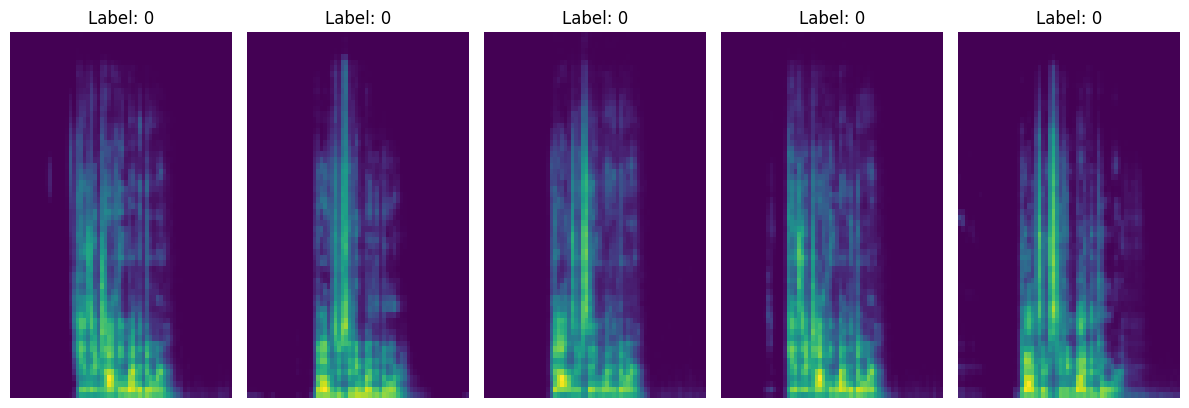

In [12]:
# Print a few samples of the spectrograms and labels
for i in range(5):  # Print first 5 samples
    print(f'Spectrogram {i}: {spectrograms[i]}')
    print(f'Label {i}: {labels[i]}')

# Visualize some spectrograms
plt.figure(figsize=(12, 8))
for i in range(5):  # Plot the first 5 spectrograms
    plt.subplot(2, 5, i + 1)
    plt.imshow(spectrograms[i], aspect='auto', origin='lower')
    plt.title(f'Label: {labels[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

### Dataset Splitting
Here, I splitted the dataset into training, validation, and test sets.

In [13]:
from sklearn.model_selection import train_test_split

# Add channel dimension for Conv2D if not already done
spectrograms = spectrograms[..., np.newaxis]  # Assuming spectrograms is (num_samples, 64, 64)

# Normalize the spectrograms
spectrograms = spectrograms.astype('float32')  # Convert to float32
spectrograms = (spectrograms - np.mean(spectrograms)) / np.std(spectrograms)  # Standardization

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(spectrograms, labels, test_size=0.3, random_state=42)  # 70% train, 30% temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 15% val, 15% test

# Check the shapes of the split datasets
print(f'Train set shape: {X_train.shape}, Labels shape: {y_train.shape}')
print(f'Validation set shape: {X_val.shape}, Labels shape: {y_val.shape}')
print(f'Test set shape: {X_test.shape}, Labels shape: {y_test.shape}')


Train set shape: (168, 64, 64, 1), Labels shape: (168,)
Validation set shape: (36, 64, 64, 1), Labels shape: (36,)
Test set shape: (36, 64, 64, 1), Labels shape: (36,)


Reshape the spectogram for CNN input

In [15]:
from skimage.transform import resize

# Function to resize spectrograms to 64x64
def resize_spectrograms(spectrograms, target_size=(64, 64)):
    resized = []
    for spec in spectrograms:
        resized_spec = resize(spec, target_size, anti_aliasing=True)
        resized.append(resized_spec)
    return np.array(resized)

# Resize training, validation, and test sets (if needed)
# If you are not resizing again, comment out the lines below
X_train_resized = resize_spectrograms(X_train)  # Only if you need to ensure resizing again
X_val_resized = resize_spectrograms(X_val)      # Only if you need to ensure resizing again
X_test_resized = resize_spectrograms(X_test)    # Only if you need to ensure resizing again

# Reshape to (samples, height, width, channels)
X_train_resized = X_train_resized.reshape(-1, 64, 64, 1)
X_val_resized = X_val_resized.reshape(-1, 64, 64, 1)
X_test_resized = X_test_resized.reshape(-1, 64, 64, 1)

# Check the new shapes
print(f'Train set resized and reshaped: {X_train_resized.shape}')
print(f'Validation set resized and reshaped: {X_val_resized.shape}')
print(f'Test set resized and reshaped: {X_test_resized.shape}')


Train set resized and reshaped: (168, 64, 64, 1)
Validation set resized and reshaped: (36, 64, 64, 1)
Test set resized and reshaped: (36, 64, 64, 1)


## Vanilla Model Implementation

In [16]:
# Convert labels to one-hot encoding for classification
y_train_one_hot = to_categorical(y_train, num_classes=8)
y_val_one_hot = to_categorical(y_val, num_classes=8)
y_test_one_hot = to_categorical(y_test, num_classes=8)



In [17]:
# Create a sequential model
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add hidden layers (fully connected)
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flattening the layer
model.add(Flatten())
model.add(Dense(128, activation='relu'))

# Output layer with 8 neurons for the emotional states
model.add(Dense(8, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,625,608 (6.20 MB)

 Trainable params: 1,625,608 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Train the model
history = model.fit(X_train_resized, y_train_one_hot,
                    validation_data=(X_val_resized, y_val_one_hot),
                    epochs=50,
                    batch_size=32)


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 306ms/step - accuracy: 0.1999 - loss: 2.5952 - val_accuracy: 0.4722 - val_loss: 1.9270
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.2892 - loss: 1.9360 - val_accuracy: 0.3333 - val_loss: 1.7788
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.3541 - loss: 1.6380 - val_accuracy: 0.2222 - val_loss: 2.2668
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.3279 - loss: 1.9237 - val_accuracy: 0.1944 - val_loss: 2.0434
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.4355 - loss: 1.6593 - val_accuracy: 0.5278 - val_loss: 1.4527
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.5927 - loss: 1.1561 - val_accuracy: 0.4167 - val_loss: 1.8121
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.6281 - loss: 1.2697 - val_accuracy: 0.5000 - val_loss: 1.3353
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.6555 - loss: 1.0568 - val_accuracy: 0.6111 - val_loss:

In [19]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_resized, y_test_one_hot)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6528 - loss: 1.6069 
Test Loss: 1.5526
Test Accuracy: 0.6667


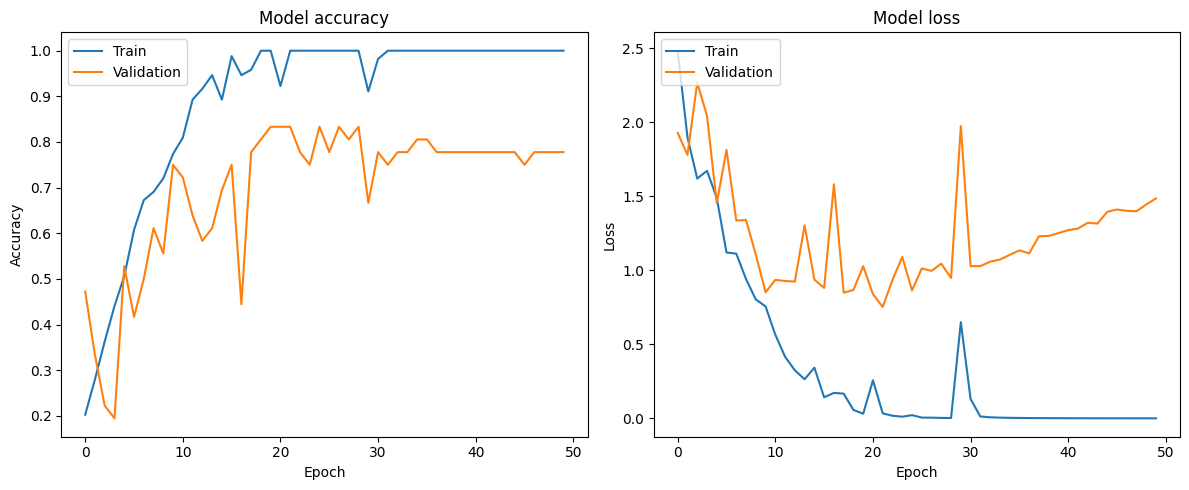

In [20]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [43]:
# Save the trained model
model.save('vanilla_model.keras')

# Optimized Model Implementation

In [25]:
# Define model architecture
model_optimized = Sequential()

# First Convolutional Layer
model_optimized.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 1), kernel_regularizer=l2(0.01)))
model_optimized.add(MaxPooling2D(pool_size=(2, 2)))

# Second Convolutional Layer
model_optimized.add(Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model_optimized.add(MaxPooling2D(pool_size=(2, 2)))

# Flattening the layer
model_optimized.add(Flatten())
model_optimized.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model_optimized.add(Dropout(0.5))  # Dropout layer to prevent overfitting

# Output layer with 8 neurons for the emotional states
model_optimized.add(Dense(8, activation='softmax'))

# Compile the model with Adam optimizer and learning rate decay
model_optimized.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model_optimized.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 62, 62, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,625,608 (6.20 MB)

 Trainable params: 1,625,608 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Learning rate reduction callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)


In [29]:
# Train the optimized model
optimized_history = model_optimized.fit(X_train_resized, y_train_one_hot,
                                         validation_data=(X_val_resized, y_val_one_hot),
                                         epochs=50,
                                         batch_size=32,
                                         callbacks=[early_stopping, reduce_lr])


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 361ms/step - accuracy: 0.1286 - loss: 4.8906 - val_accuracy: 0.3611 - val_loss: 3.8814 - learning_rate: 0.0010
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - accuracy: 0.2736 - loss: 3.7093 - val_accuracy: 0.4444 - val_loss: 3.1733 - learning_rate: 0.0010
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.2234 - loss: 3.2159 - val_accuracy: 0.3889 - val_loss: 2.8539 - learning_rate: 0.0010
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.2692 - loss: 2.8988 - val_accuracy: 0.3611 - val_loss: 2.6675 - learning_rate: 0.0010
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 0.3059 - loss: 2.6127 - val_accuracy: 0.4444 - val_loss: 2.4136 - learning_rate: 0.0010
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - accuracy: 0.3315 - loss: 2.4562 - val_accuracy: 0.4444 - val_loss: 2.2537 - learning_rate: 0.0010
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.4081 - loss: 2.2073 - val_accuracy: 

In [33]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_resized, y_test_one_hot)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7789 - loss: 1.3860
Test Loss: 1.4849
Test Accuracy: 0.7778


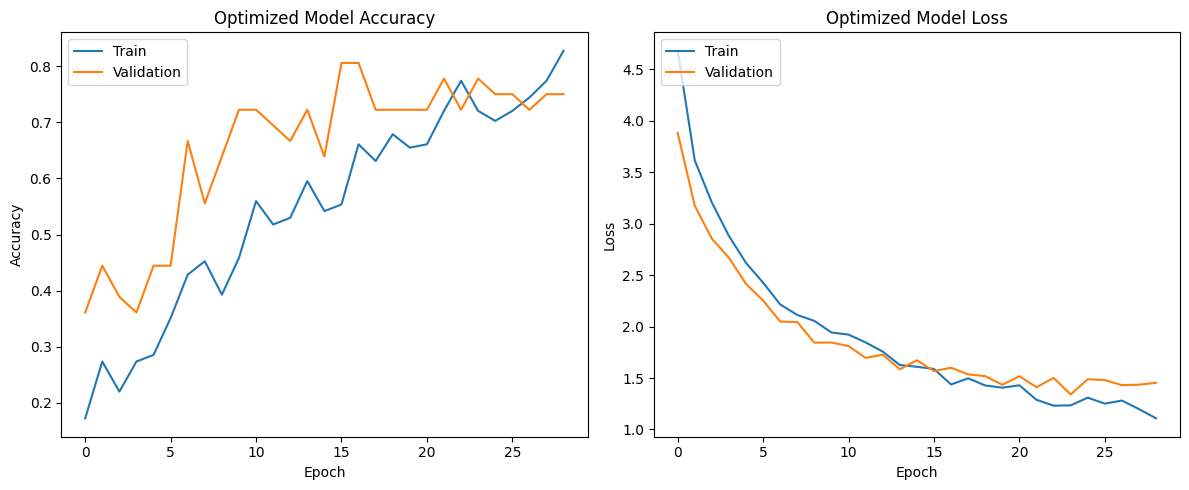

In [32]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(optimized_history.history['accuracy'])
plt.plot(optimized_history.history['val_accuracy'])
plt.title('Optimized Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(optimized_history.history['loss'])
plt.plot(optimized_history.history['val_loss'])
plt.title('Optimized Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [42]:
# Save the trained model
model_optimized.save('optimized_model.keras')

## Error Analysis


Optimized Model Analysis:
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

Confusion Matrix:
 [[0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 1 0]
 [0 0 5 0 2 0 0 0]
 [1 0 1 4 0 1 0 0]
 [0 0 0 0 4 0 0 0]
 [0 0 0 0 0 2 0 2]
 [0 0 0 1 1 0 2 0]
 [1 0 0 0 0 1 0 4]]

Classification Report:
               precision    recall  f1-score   support

     Neutral       0.00      0.00      0.00         0
        Calm       1.00      0.75      0.86         4
       Happy       0.83      0.71      0.77         7
         Sad       0.80      0.57      0.67         7
       Angry       0.57      1.00      0.73         4
     Fearful       0.50      0.50      0.50         4
     Disgust       0.67      0.50      0.57         4
   Surprised       0.67      0.67      0.67         6

    accuracy                           0.67        36
   macro avg       0.63      0.59      0.59        36
weighted avg       0.73      0.67      0.69        36


Model Performance Metrics:
Accuracy: 0.6667
Precision (Macro): 0.6298
Recall (Macro):

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.p

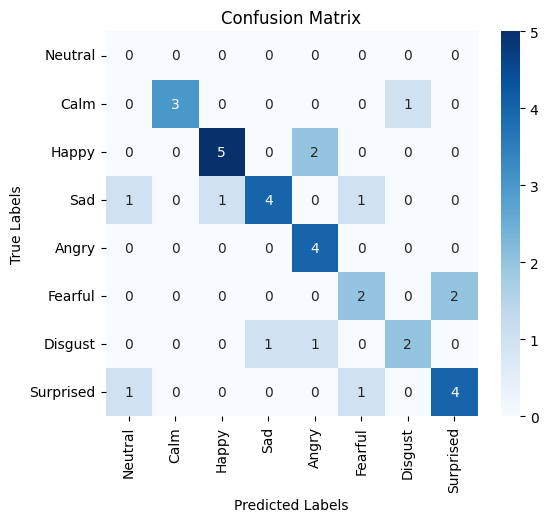

Vanilla Model Analysis:
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

Confusion Matrix:
 [[0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0]
 [0 0 3 1 2 0 0 1]
 [1 0 0 3 0 3 0 0]
 [0 0 1 0 3 0 0 0]
 [0 0 2 0 0 1 0 1]
 [1 1 0 0 1 0 1 0]
 [1 0 0 1 0 1 0 3]]

Classification Report:
               precision    recall  f1-score   support

     Neutral       0.00      0.00      0.00         0
        Calm       0.80      1.00      0.89         4
       Happy       0.50      0.43      0.46         7
         Sad       0.60      0.43      0.50         7
       Angry       0.50      0.75      0.60         4
     Fearful       0.20      0.25      0.22         4
     Disgust       1.00      0.25      0.40         4
   Surprised       0.60      0.50      0.55         6

    accuracy                           0.50        36
   macro avg       0.53      0.45      0.45        36
weighted avg       0.59      0.50      0.51        36


Model Performance Metrics:
Accuracy: 0.5000
Precision (Macro): 0.5250
Recall (Macro): 0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.p

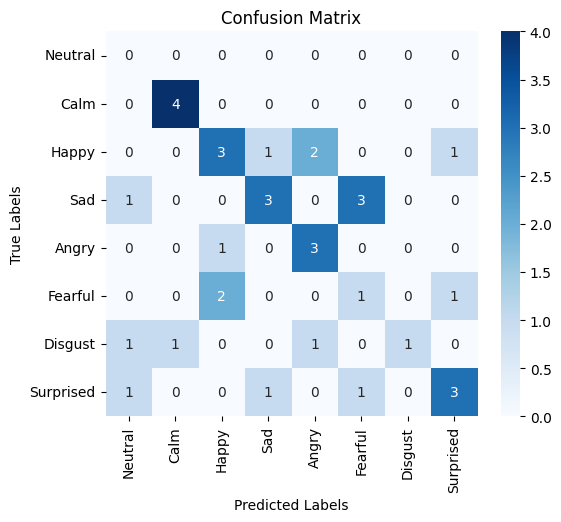

In [38]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Function to perform error analysis
def error_analysis(model, X_test, y_test, class_names):
    # Get true labels and predictions from the test set
    y_true = []
    y_pred = []

    # Predict on test set
    preds = model.predict(X_test)
    y_true.extend(y_test)  # True labels
    y_pred.extend(np.argmax(preds, axis=1))  # Predicted labels

    # Convert lists to numpy arrays for compatibility with metrics
    y_true = np.array(y_true).astype(int)  # Ensure y_true is integer type
    y_pred = np.array(y_pred)

    # Step 2: Confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    print("\nConfusion Matrix:\n", conf_matrix)

    # Step 3: Generate a classification report
    print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=class_names))

    # Step 4: Calculate additional metrics: Accuracy, Precision, Recall, F1 Score
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')  # 'macro' for multiclass precision
    recall = recall_score(y_true, y_pred, average='macro')  # 'macro' for multiclass recall
    f1 = f1_score(y_true, y_pred, average='macro')  # 'macro' for multiclass F1-score

    # Print the calculated metrics
    print(f"\nModel Performance Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Macro): {precision:.4f}")
    print(f"Recall (Macro): {recall:.4f}")
    print(f"F1 Score (Macro): {f1:.4f}")

    # Step 5: Visualize the confusion matrix as a heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Define class names
class_names = ['Neutral', 'Calm', 'Happy', 'Sad', 'Angry', 'Fearful', 'Disgust', 'Surprised']

# Perform error analysis for the vanilla model
print("\nOptimized Model Analysis:")
error_analysis(model_optimized, X_test_resized, y_test, class_names)

# Perform error analysis for the optimized model
print("Vanilla Model Analysis:")
error_analysis(model, X_test_resized, y_test, class_names)
